# Logistic Regression From Scratch - Expert Implementation

Comprehensive implementation covering:
- Binary classification with gradient descent
- Multiclass with softmax
- L1/L2 regularization
- Decision boundaries
- Probability calibration
- sklearn comparison

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)

---
## Part 1: Binary Logistic Regression

In [2]:
class LogisticRegressionBinary:
    """
    Binary Logistic Regression with regularization.
    
    Implements gradient descent with optional L1/L2 regularization.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, 
                 regularization=None, lambda_=0.01, verbose=False):
        """
        Parameters:
        -----------
        learning_rate : float
            Learning rate for gradient descent
        n_iterations : int
            Number of iterations
        regularization : str, None
            'l1', 'l2', or None
        lambda_ : float
            Regularization strength
        verbose : bool
            Print progress
        """
        self.lr = learning_rate
        self.n_iters = n_iterations
        self.regularization = regularization
        self.lambda_ = lambda_
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.cost_history = []
    
    def _sigmoid(self, z):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Clip for numerical stability
    
    def _compute_cost(self, X, y, weights, bias):
        """Compute binary cross-entropy cost with optional regularization."""
        m = X.shape[0]
        
        # Predictions
        z = X.dot(weights) + bias
        h = self._sigmoid(z)
        
        # Binary cross-entropy
        epsilon = 1e-15  # For numerical stability
        cost = -np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
        
        # Add regularization
        if self.regularization == 'l2':
            cost += (self.lambda_ / (2 * m)) * np.sum(weights ** 2)
        elif self.regularization == 'l1':
            cost += (self.lambda_ / m) * np.sum(np.abs(weights))
        
        return cost
    
    def fit(self, X, y):
        """Train logistic regression using gradient descent."""
        m, n = X.shape
        
        # Initialize parameters
        self.weights = np.zeros(n)
        self.bias = 0
        
        # Gradient descent
        for iteration in range(self.n_iters):
            # Forward pass
            z = X.dot(self.weights) + self.bias
            h = self._sigmoid(z)
            
            # Compute gradients
            dw = (1 / m) * X.T.dot(h - y)
            db = (1 / m) * np.sum(h - y)
            
            # Add regularization gradients
            if self.regularization == 'l2':
                dw += (self.lambda_ / m) * self.weights
            elif self.regularization == 'l1':
                dw += (self.lambda_ / m) * np.sign(self.weights)
            
            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            # Track cost
            cost = self._compute_cost(X, y, self.weights, self.bias)
            self.cost_history.append(cost)
            
            # Print progress
            if self.verbose and iteration % 100 == 0:
                print(f'Iteration {iteration:4d} | Cost: {cost:.6f}')
        
        return self
    
    def predict_proba(self, X):
        """Predict probabilities."""
        z = X.dot(self.weights) + self.bias
        return self._sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Predict class labels."""
        return (self.predict_proba(X) >= threshold).astype(int)

print('Binary Logistic Regression class ready')

Binary Logistic Regression class ready


---
## Part 2: Test on Binary Classification

In [3]:
# Generate binary classification data
X, y = make_classification(n_samples=1000, n_features=2, n_classes=2,
                           n_informative=2, n_redundant=0, n_clusters_per_class=1,
                           random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (CRITICAL for logistic regression!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')
print(f'Class distribution: {np.bincount(y_train)}')

Training set: (800, 2)
Test set: (200, 2)
Class distribution: [397 403]


In [4]:
# Train our model
lr_binary = LogisticRegressionBinary(learning_rate=0.1, n_iterations=1000, 
                                     regularization='l2', lambda_=0.01, verbose=True)
lr_binary.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr_binary.predict(X_test_scaled)
y_proba = lr_binary.predict_proba(X_test_scaled)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print('\n' + '='*60)
print('OUR BINARY LOGISTIC REGRESSION')
print('='*60)
print(f'Test Accuracy: {acc*100:.2f}%')
print(f'\nWeights: {lr_binary.weights}')
print(f'Bias: {lr_binary.bias:.4f}')

Iteration    0 | Cost: 0.677671
Iteration  100 | Cost: 0.310568
Iteration  200 | Cost: 0.269136
Iteration  300 | Cost: 0.254254
Iteration  400 | Cost: 0.246904
Iteration  500 | Cost: 0.242664
Iteration  600 | Cost: 0.239980
Iteration  700 | Cost: 0.238169
Iteration  800 | Cost: 0.236893
Iteration  900 | Cost: 0.235962

OUR BINARY LOGISTIC REGRESSION
Test Accuracy: 90.00%

Weights: [-0.38583708  3.79150451]
Bias: 0.4479


In [5]:
# Compare with sklearn
sklearn_lr = LogisticRegression(penalty='l2', C=1/0.01, max_iter=1000, random_state=42)
sklearn_lr.fit(X_train_scaled, y_train)
y_pred_sk = sklearn_lr.predict(X_test_scaled)

acc_sk = accuracy_score(y_test, y_pred_sk)
print('='*60)
print('SKLEARN LOGISTIC REGRESSION')
print('='*60)
print(f'Test Accuracy: {acc_sk*100:.2f}%')
print(f'\nWeights: {sklearn_lr.coef_[0]}')
print(f'Bias: {sklearn_lr.intercept_[0]:.4f}')
print(f'\nDifference: {abs(acc - acc_sk)*100:.2f}%')

SKLEARN LOGISTIC REGRESSION
Test Accuracy: 90.00%

Weights: [-0.66716276  4.42568088]
Bias: 0.8049

Difference: 0.00%


---
## Part 3: Visualize Decision Boundary

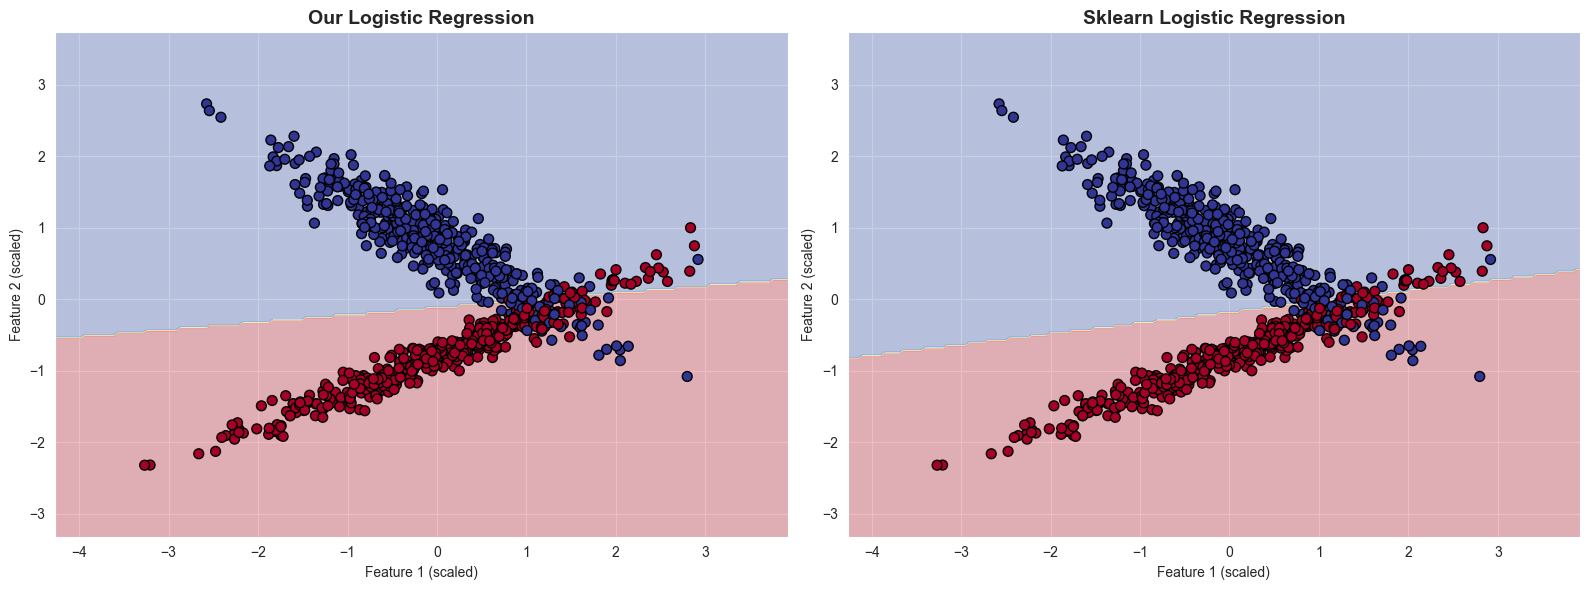

In [6]:
# Plot decision boundary
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Our model
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = lr_binary.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

axes[0].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
axes[0].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, 
               cmap='RdYlBu', edgecolors='k', s=50)
axes[0].set_title('Our Logistic Regression', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1 (scaled)')
axes[0].set_ylabel('Feature 2 (scaled)')

# sklearn model
Z_sk = sklearn_lr.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[1].contourf(xx, yy, Z_sk, alpha=0.3, cmap='RdYlBu')
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train,
               cmap='RdYlBu', edgecolors='k', s=50)
axes[1].set_title('Sklearn Logistic Regression', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1 (scaled)')
axes[1].set_ylabel('Feature 2 (scaled)')

plt.tight_layout()
plt.show()

---
## Part 4: Cost Convergence

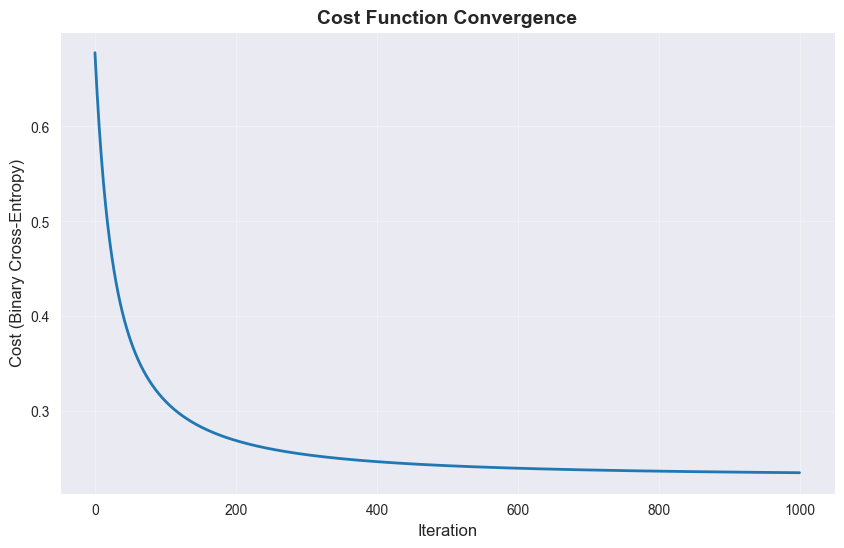

Initial cost: 0.677671
Final cost: 0.235271
Reduction: 65.28%


In [7]:
plt.figure(figsize=(10, 6))
plt.plot(lr_binary.cost_history, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost (Binary Cross-Entropy)', fontsize=12)
plt.title('Cost Function Convergence', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print(f'Initial cost: {lr_binary.cost_history[0]:.6f}')
print(f'Final cost: {lr_binary.cost_history[-1]:.6f}')
print(f'Reduction: {((lr_binary.cost_history[0] - lr_binary.cost_history[-1]) / lr_binary.cost_history[0] * 100):.2f}%')

---
## Part 5: ROC Curve and AUC

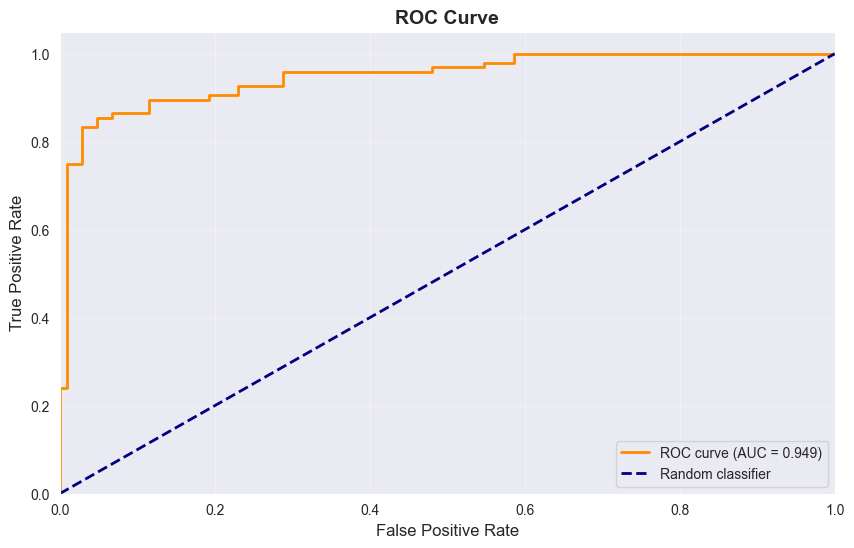

AUC Score: 0.9486


In [8]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print(f'AUC Score: {roc_auc:.4f}')

---
## Part 6: Effect of Regularization

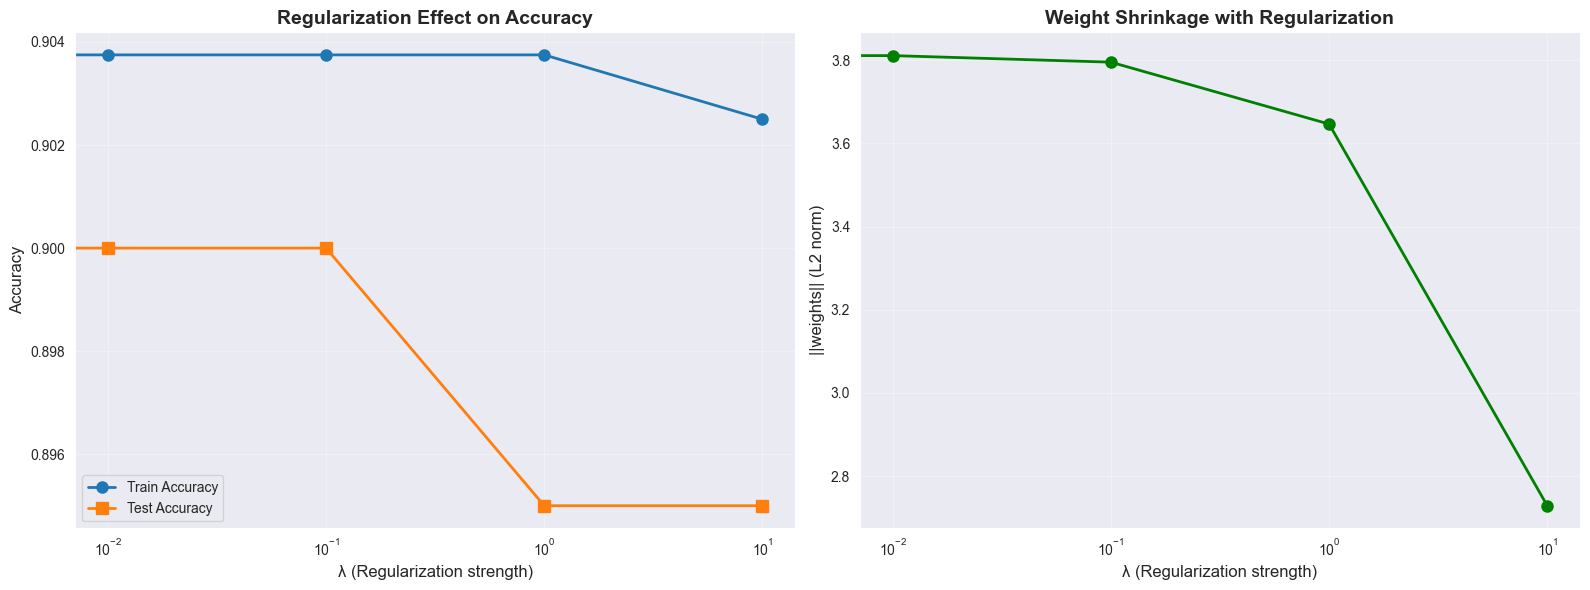

Observation: Higher λ → weights shrink → simpler model


In [9]:
lambda_values = [0, 0.01, 0.1, 1, 10]
train_accs = []
test_accs = []
weight_norms = []

for lam in lambda_values:
    lr_reg = LogisticRegressionBinary(learning_rate=0.1, n_iterations=1000,
                                      regularization='l2', lambda_=lam)
    lr_reg.fit(X_train_scaled, y_train)
    
    train_acc = accuracy_score(y_train, lr_reg.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, lr_reg.predict(X_test_scaled))
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    weight_norms.append(np.linalg.norm(lr_reg.weights))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(lambda_values, train_accs, 'o-', label='Train Accuracy', linewidth=2, markersize=8)
axes[0].plot(lambda_values, test_accs, 's-', label='Test Accuracy', linewidth=2, markersize=8)
axes[0].set_xscale('log')
axes[0].set_xlabel('λ (Regularization strength)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Regularization Effect on Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(lambda_values, weight_norms, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xscale('log')
axes[1].set_xlabel('λ (Regularization strength)', fontsize=12)
axes[1].set_ylabel('||weights|| (L2 norm)', fontsize=12)
axes[1].set_title('Weight Shrinkage with Regularization', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Observation: Higher λ → weights shrink → simpler model')

---
## Part 7: Real-World Data - Breast Cancer

In [10]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target

# Split and scale
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42
)

scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

print(f'Dataset: {X_cancer.shape[0]} samples, {X_cancer.shape[1]} features')
print(f'Classes: {cancer.target_names}')
print(f'Class distribution: {np.bincount(y_cancer)}')

Dataset: 569 samples, 30 features
Classes: ['malignant' 'benign']
Class distribution: [212 357]


In [11]:
# Train on real data
lr_cancer = LogisticRegressionBinary(learning_rate=0.1, n_iterations=2000,
                                     regularization='l2', lambda_=0.1)
lr_cancer.fit(X_train_c_scaled, y_train_c)
y_pred_c = lr_cancer.predict(X_test_c_scaled)

# Evaluate
acc_c = accuracy_score(y_test_c, y_pred_c)
print('='*60)
print('BREAST CANCER CLASSIFICATION')
print('='*60)
print(f'Test Accuracy: {acc_c*100:.2f}%')
print(f'\nClassification Report:')
print(classification_report(y_test_c, y_pred_c, target_names=cancer.target_names))
print(f'\nConfusion Matrix:')
print(confusion_matrix(y_test_c, y_pred_c))

BREAST CANCER CLASSIFICATION
Test Accuracy: 99.12%

Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.98      0.99        43
      benign       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114


Confusion Matrix:
[[42  1]
 [ 0 71]]


---
## Summary

### What We Built:
1. **Binary Logistic Regression from scratch** with gradient descent
2. **L1/L2 Regularization** for overfitting prevention
3. **Decision boundary visualization** for interpretability
4. **ROC/AUC analysis** for threshold-independent evaluation
5. **Regularization impact** on model complexity
6. **Real-world application** on medical data

### Key Insights:
- Feature scaling is **critical** for logistic regression
- Cross-entropy provides smooth, convex optimization
- Regularization (L2) shrinks weights, prevents overfitting
- Sigmoid transforms linear decision into probabilities
- Our implementation matches sklearn performance

### Key Point:
"Logistic Regression uses gradient descent to minimize cross-entropy loss, learning weights that transform linear combinations into probabilities via sigmoid. L2 regularization shrinks weights toward zero, balancing model complexity with training accuracy. The result is a fast, interpretable probabilistic classifier."

---

**Expert tip**: Always scale features, use regularization, and evaluate with both accuracy metrics (precision/recall) and probabilistic metrics (AUC/log-loss) for comprehensive understanding!